In [1]:
import sys

sys.path.append('./source/')

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import reproject
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy import integrate, stats
from scipy import interpolate as intp
import importlib
import healpy


from source import plots
from source import prob_dists as pd
from utils import read_param_file, update_params


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
gal_background_file = 'output/gll_iem_v07.fits'
iso_background_file = 'output/iso_P8R3_SOURCE_V2_FRONT_v1.txt'
param_file = './source/n0.params'

params = read_param_file(param_file)
nside = params['nside']
omega_pixel = params['omega_pixel']

gal_flux_file = './output/gal_flux_bg.npy'

gal_bg = fits.open(gal_background_file)
iso_bg = np.loadtxt(iso_background_file, delimiter=" ", dtype=np.float64)

(28, 1441, 2880)
Filename: output/gll_iem_v07.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   (2880, 1441, 28)   float32   
  1  ENERGIES      1 BinTableHDU     12   28R x 1C   [D]   


(None,
 SIMPLE  =                    T / conforms to FITS standard                      
 BITPIX  =                  -32 / array data type                                
 NAXIS   =                    3 / number of array dimensions                     
 NAXIS1  =                 2880                                                  
 NAXIS2  =                 1441                                                  
 NAXIS3  =                   28                                                  
 EXTEND  =                    T                                                  
 CRVAL1  =                    0                                                  
 CDELT1  =               -0.125                                                  
 CRPIX1  =               1440.5                                                  
 CTYPE1  = 'GLON-CAR'                                                            
 CUNIT1  = 'deg     '                                                            
 CRVAL2  

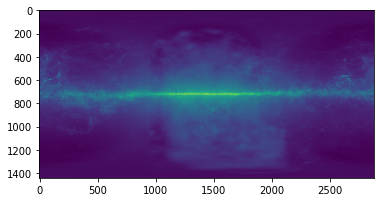

In [4]:
plt.imshow(np.log10(gal_bg[0].data[0, :, :]))
print(gal_bg[0].data.shape)
gal_bg.info(), gal_bg[0].header, gal_bg[1].data

/usr/local/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


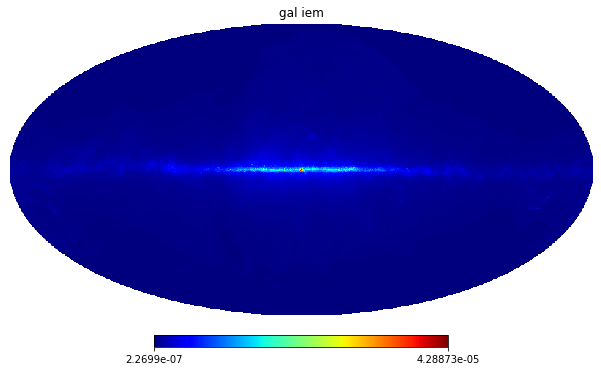

In [5]:
wcs = WCS(gal_bg[0].header).dropaxis(2)
transtohpx, footprint = reproject.reproject_to_healpix((gal_bg[0].data[0], wcs), 'galactic', nside=nside)
healpy.mollview(transtohpx, cmap=cm.jet, title="gal iem")

In [6]:
np.mean(np.nan_to_num(transtohpx)), np.mean(gal_bg[0].data), healpy.nside2npix(nside), 2880 * 1441

(8.2505653e-07, 6.82764e-08, 196608, 4150080)

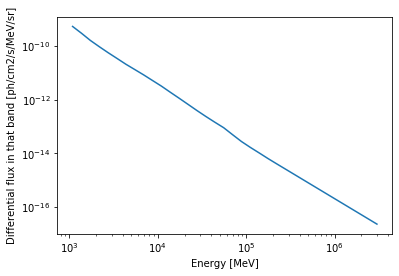

In [7]:
gev_index = 15
plt.plot(iso_bg[gev_index:, 0], iso_bg[gev_index:, 1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Differential flux in that band [ph/cm2/s/MeV/sr]');

In [8]:
seconds_to_yr = 365 * 24 * 60 * 60

gev_index = 15
iso_flux = integrate.simps(iso_bg[gev_index:, 1], iso_bg[gev_index:, 0]) * omega_pixel * seconds_to_yr
# iso_flux = np.trapz(iso_bg[gev_index:, 1], iso_bg[gev_index:, 0]) * omega_pixel * seconds_to_yr
params = update_params(param_file, params, 'iso_flux_bg', iso_flux)
params = update_params(param_file, params, 'gal_flux_bg_file', gal_flux_file)

gev_index = 12
gal_flux = integrate.simps(gal_bg[0].data[gev_index:], gal_bg[1].data.astype(np.float64)[gev_index:], axis=0) * omega_pixel * seconds_to_yr
# gal_flux = np.trapz(gal_bg[0].data[gev_index:], gal_bg[1].data.astype(np.float64)[gev_index:], axis=0) * omega_pixel * seconds_to_yr

wcs = WCS(gal_bg[0].header).dropaxis(2)
transtohpx, footprint = reproject.reproject_to_healpix((gal_flux, wcs), 'galactic', nside=nside)

np.save(gal_flux_file, np.nan_to_num(transtohpx))

print(iso_flux)

0.0008615905978150363


In [9]:
param_file = './source/n-1.params'
params = update_params(param_file, params, 'iso_flux_bg', iso_flux)
params = update_params(param_file, params, 'gal_flux_bg_file', gal_flux_file)

/usr/local/lib/python3.8/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:1184: RuntimeWarning: invalid value encountered in less
  result.data[result.data < 0] = 0.0
/usr/local/lib/python3.8/site-packages/healpy/projaxes.py:1185: RuntimeWarning: invalid value encountered in greater
  result.data[result.data > 1] = 1.0


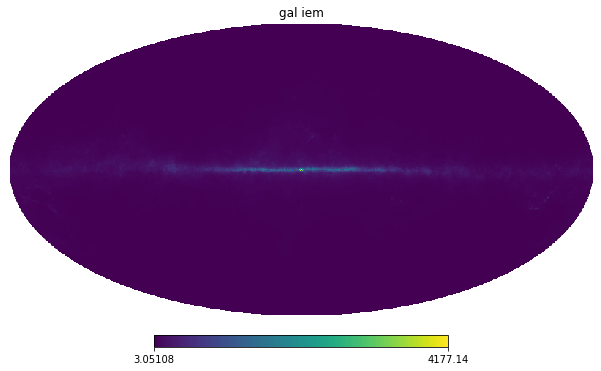

In [10]:
healpy.mollview(transtohpx * params['exposure'], cmap=cm.viridis, title="gal iem")

In [11]:
iso_flux * params['exposure']

4.799424089731747

In [12]:
import healpy


In [13]:
healpy.nside2pixarea(params['nside']) 

6.391586616190171e-05

In [14]:
params['omega_pixel']

6.391586616190171e-05

In [15]:
14000/(4 * np.pi) * 5 / seconds_to_yr * 1e8

17663.695485211625

In [16]:
import scipy
iso_flux = scipy.integrate.simps(iso_bg[gev_index:, 1], iso_bg[gev_index:, 0]) * omega_pixel * seconds_to_yr

In [17]:
iso_flux * params['exposure']

12.571283018490439

In [18]:
gal_bg[0].data[0].mean()

6.479795e-07

In [19]:
minbg = []
for bg in gal_bg[0].data:
    minbg.append(bg.min())
    
meanbg = []
for bg in gal_bg[0].data:
    meanbg.append(bg.mean())

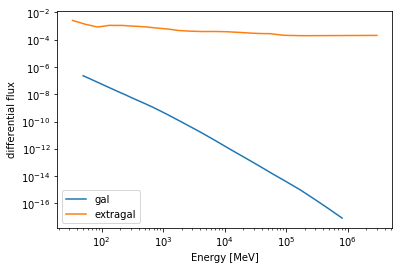

In [20]:
plt.plot(gal_bg[1].data.astype(np.float64), minbg, label='gal')
plt.plot(iso_bg[:, 0], iso_bg[:, 1] * iso_bg[:, 0]**2 , label='extragal')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('differential flux')
plt.legend()